## Week 02 | Lecture Recode

In [1]:
# !pip install line_profiler

In [0]:
import os
import time
import random
import cv2
import numpy as np
from skimage import io
from line_profiler import LineProfiler
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt

### First，展示一下本周code示例的主角~

铛铛~今天是，水族馆~~


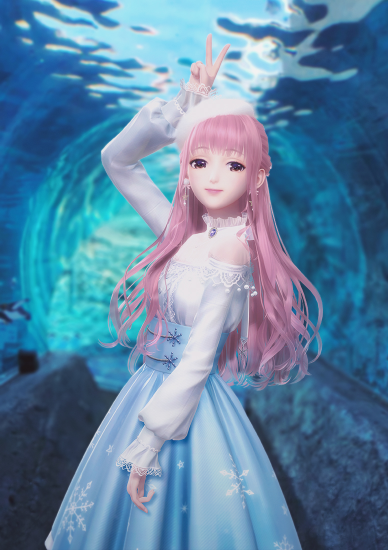

In [9]:
print("铛铛~今天是，水族馆~~")
img_address = 'https://drive.google.com/uc?id=138TOCvAUysOnNkd_msYuHw6xUzRoITVQ'
img = cv2.cvtColor(io.imread(img_address).astype(np.uint8), cv2.COLOR_RGB2BGR)
# img = io.imread(img_address).astype(np.uint8)[:, :, (2, 1, 0)]  # the same but too slow

H, W, C = img.shape  # (1100, 776, 3)
img = cv2.resize(img, dsize=(int(W/2), int(H/2)))
cv2_imshow(img)

# I. Image Processing (Low Level)

## 1. Gaussian Kernel Effect

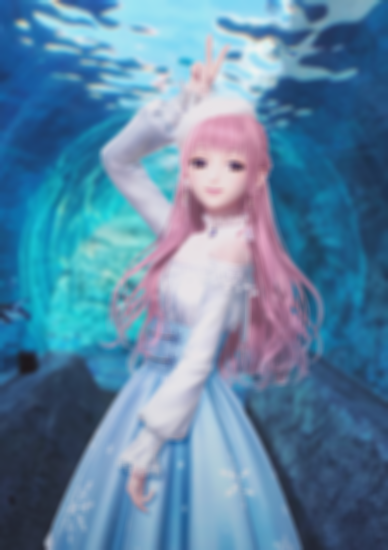

In [0]:
# Gaussian Kernel Effect
g_img_7_5 = cv2.GaussianBlur(img,(7,7),sigmaX=5)
cv2_imshow(g_img_7_5)

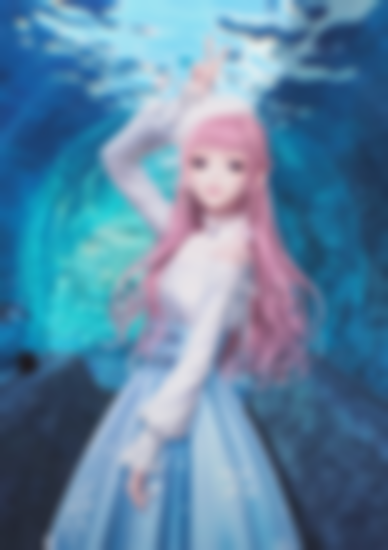

In [0]:
g_img_17_5 = cv2.GaussianBlur(img, (17, 17), 5)
cv2_imshow(g_img_17_5)
# 图像变更模糊，因为ksize范围更大，平均效果更明显

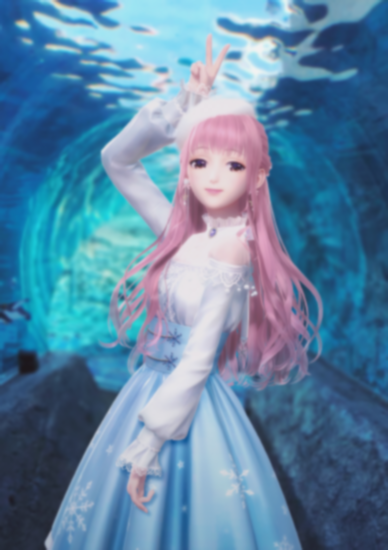

In [0]:
g_img_17_1 = cv2.GaussianBlur(img, (17, 17),sigmaX=1)
cv2_imshow(g_img_17_1)
# 图像更清晰，因为方差更小，高斯图像更尖锐，中心点起的作用更大

#### 来看看高斯核：

In [51]:
kernel = cv2.getGaussianKernel(ksize=7, sigma=5)
print(kernel)

[[0.12895603]
 [0.14251846]
 [0.15133131]
 [0.1543884 ]
 [0.15133131]
 [0.14251846]
 [0.12895603]]


#### 为啥一维? 因为一维运算快

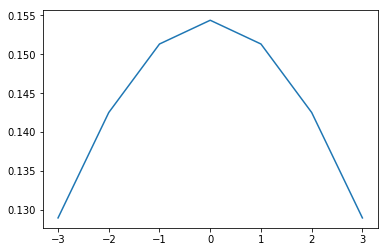

0.12895603354653198 0.12895603354653198


In [52]:
y = kernel.ravel()
x = list(range(-3, 4))
plt.plot(x, y)
plt.show()

p1, p2 = np.percentile(kernel,0.25), np.percentile(kernel,0.975)
print(p1, p2)
# 确实是正态的

Timer unit: 1e-06 s

Total time: 4.7108 s
File: <ipython-input-55-1781267451c4>
Function: runtime_test at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def runtime_test(num):
     2      1501    2367666.0   1577.4     50.3      for i in range(num): cv2.GaussianBlur(img,(7,7),5)
     3      1501    2343136.0   1561.0     49.7      for i in range(num): cv2.sepFilter2D(img, ddepth=-1, kernelX=kernel, kernelY=kernel)



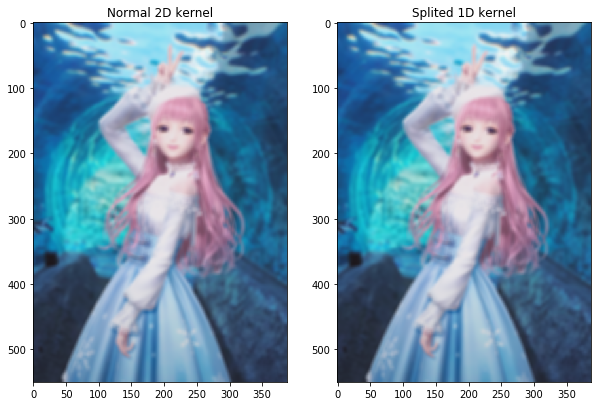

In [55]:
# 一维运算快: 理论解释
# 看【隐式高斯】和【显式分步高斯】的效果
def runtime_test(num):
    for i in range(num): cv2.GaussianBlur(img,(7,7),5)
    for i in range(num): cv2.sepFilter2D(img, ddepth=-1, kernelX=kernel, kernelY=kernel)

lp = LineProfiler()
lp_wrapper = lp(runtime_test)
lp_wrapper(1500)
lp.print_stats()

plt.figure(figsize=(10, 30))
plt.subplot(121)
plt.title('Normal 2D kernel')
plt.imshow(cv2.cvtColor(g1_img, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.title('Splited 1D kernel')
plt.imshow(cv2.cvtColor(g2_img, cv2.COLOR_BGR2RGB))
plt.show()

## 2. Other Applications

### (1) $2_{nd}$ derivative: 以$45^{°}$为增量的旋转不变Laplacian算子 （双边缘效果）


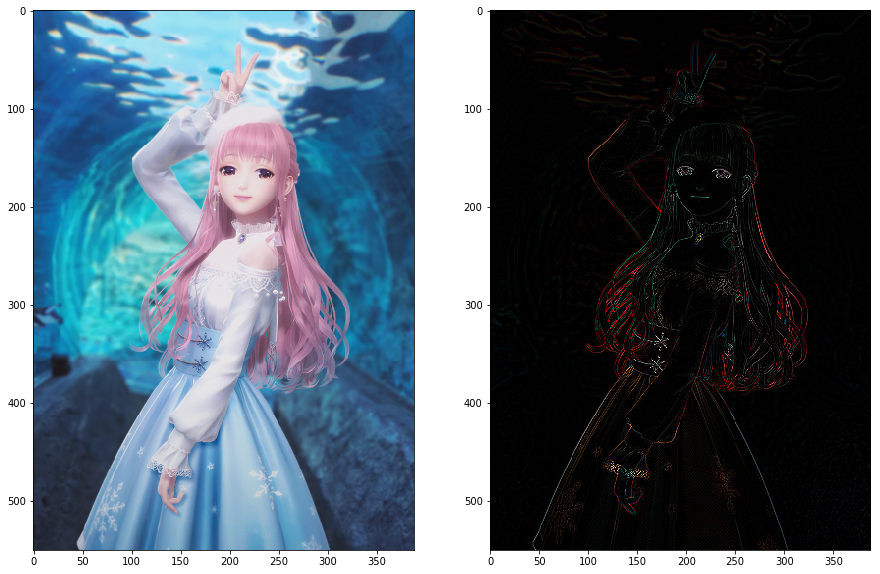

In [0]:
kernel_lap = np.array([[0, 1., 0],
                       [1, -4, 1],
                       [0, 1., 0]], dtype=np.float32)
lap_img = cv2.filter2D(img, ddepth=-1, kernel=kernel_lap)
# cv2_imshow(lap_img)
plt.figure(figsize=(15, 30))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(lap_img, cv2.COLOR_BGR2RGB))
plt.show()

### (2) 图像锐化:  sharppen = edge+origin
>原像 + edge: 更锐利地图像，因为突出边缘 

In [0]:
# 原图 + edge:
kernel_sharp = np.array([[0,0,0], [0,1,0],[0,0,0]],np.float32) + kernel_lap
print(kernel_sharp)

[[ 0.  1.  0.]
 [ 1. -3.  1.]
 [ 0.  1.  0.]]


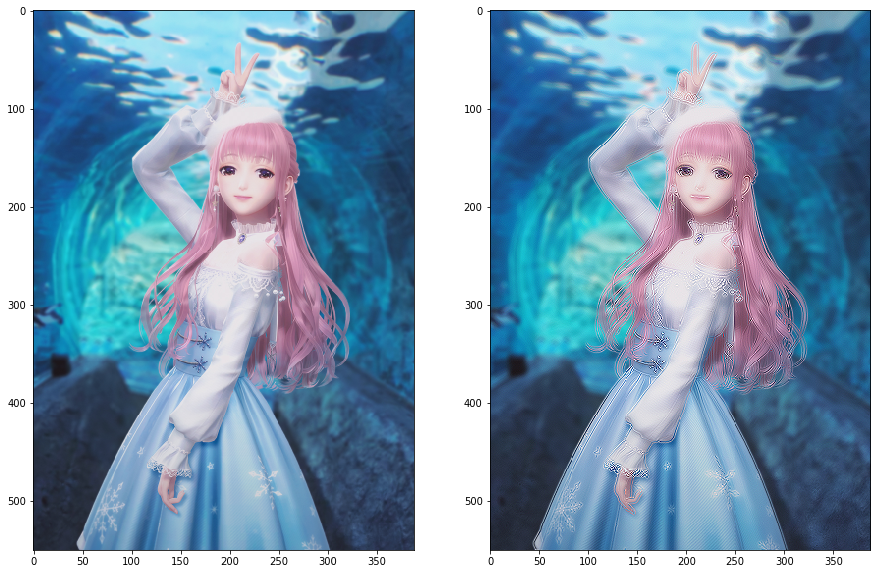

In [0]:
sharp_img = cv2.filter2D(img, -1, kernel_sharp)
plt.figure(figsize=(15, 30))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(sharp_img, cv2.COLOR_BGR2RGB))
plt.show()
# cv2_imshow(sharp_img)

>这样不对：周围有4个1，中间是-3，虽然有边缘效果，但是周围的1会使得原kernel有滤波效果，使图像模糊；  

>解决：取kernel_lap的相反数，再加上原图像，这样突出了中心像素，效果类似于小方差的高斯，所以可以既有边缘效果，又保留图像清晰度.

> 注意：这里和Laplacian的定义有关，如果所用的定义的中心系数是负的，想要得到锐化的结果，加必须从原图中减去经Laplacian变换的后的图像，而不会是加上它。  

>因此，使用拉普拉斯增强图像的基本方法可表示为下式：  
* $g(x, y) = f(x, y) + c[\nabla^2f(x, y)]$，  
若中心系数为负，则常数$c = -1$；否则为$1$。

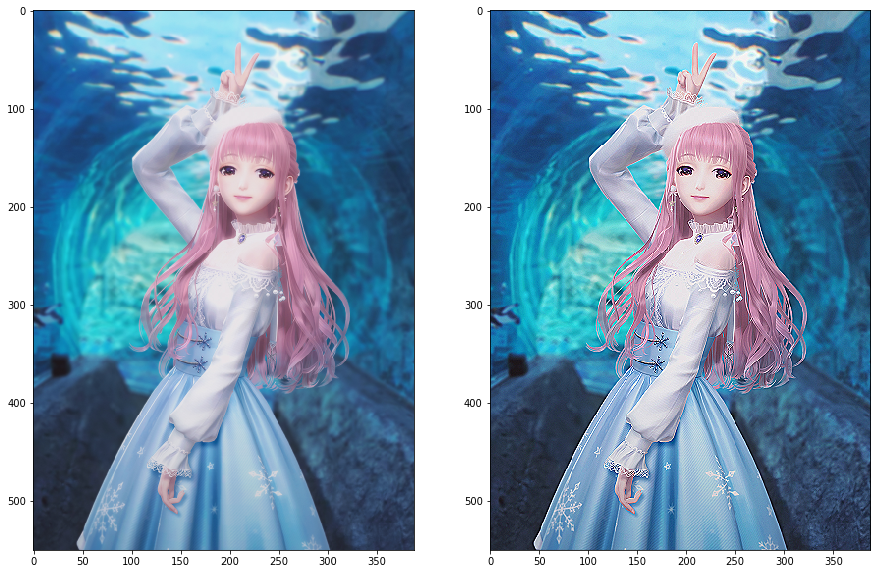

In [58]:
# 使用中心系数为负的laplacian filter: sharppen filiter = origin - 2nd laplacian operator
kernel_sharp = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], np.float32)
sharp_img = cv2.filter2D(img, -1, kernel_sharp)
plt.figure(figsize=(15, 30))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(sharp_img, cv2.COLOR_BGR2RGB))
plt.show()

>更“凶猛”的边缘效果：以$45^{°}$为增量的旋转不变拉普拉斯算子  
不仅考虑x-y方向上的梯度，同时考虑了对角线方向上的梯度

In [4]:
kernel_s_lap = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], np.float32)
print(kernel_s_lap)

[[ 1.  1.  1.]
 [ 1. -8.  1.]
 [ 1.  1.  1.]]


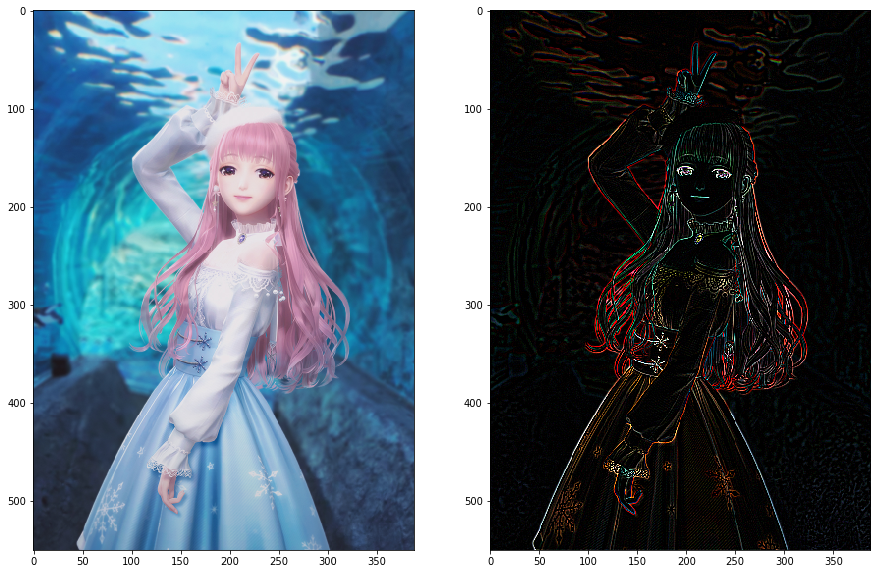

In [0]:
s_lap_img = cv2.filter2D(img, -1, kernel_s_lap)
plt.figure(figsize=(15, 30))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(s_lap_img, cv2.COLOR_BGR2RGB))
plt.show()

> 更“sharp”的锐化效果：

In [5]:
kernel_ssharp = -kernel_s_lap + np.array([[0,0,0], [0,1,0],[0,0,0]],np.float32)
print(kernel_ssharp)

[[-1. -1. -1.]
 [-1.  9. -1.]
 [-1. -1. -1.]]


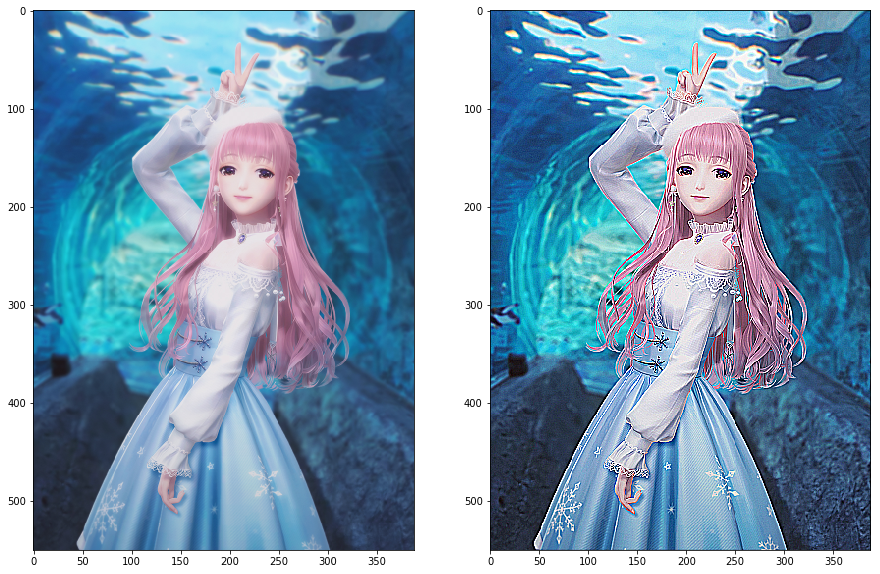

In [0]:
ssharp_img = cv2.filter2D(img, -1, kernel_ssharp)
plt.figure(figsize=(15, 30))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(ssharp_img, cv2.COLOR_BGR2RGB))
plt.show()

>看到裙子上的暗纹了吗！！！！  
~~ớ ₃ờ 我就想问问IOS大陆版到底什么时候公测？!~~ **IOS版8月10日公测！！**   



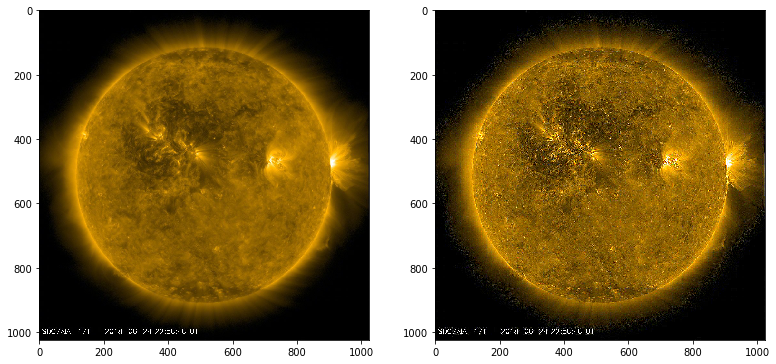

In [7]:
img_sun = io.imread("https://drive.google.com/uc?id=1RMkSuIlbfltR9Z9EqL06Kbpz3Vh6mZMT")
plt.figure(figsize=(13, 13))
plt.subplot(121)
plt.imshow(img_sun)
ssharp_sun = cv2.filter2D(img_sun, -1, kernel_ssharp)
plt.subplot(122)
plt.imshow(ssharp_sun)
plt.show()

## 3. 边缘检测：Sobel算子

### (1) x轴方向的一阶微分：Sobel算子$grad(x)$

In [0]:
grad_x = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], np.float32)
print(grad_x)

[[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  1.]]


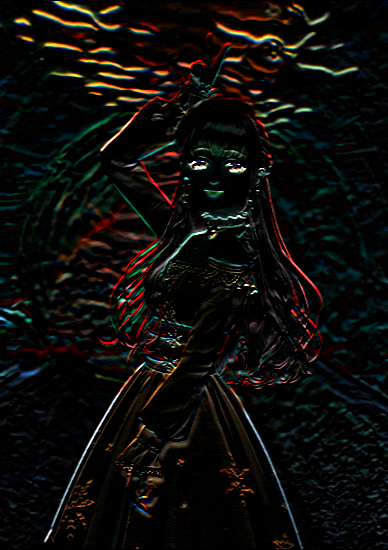

In [0]:
edgeX_img = cv2.filter2D(img, -1, kernel=grad_x)
cv2_imshow(edgeX_img)

### (2) y轴方向的一阶微分：Sobel算子$grad(y)$

In [0]:
grad_y = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], np.float32)
print(grad_y)

[[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]


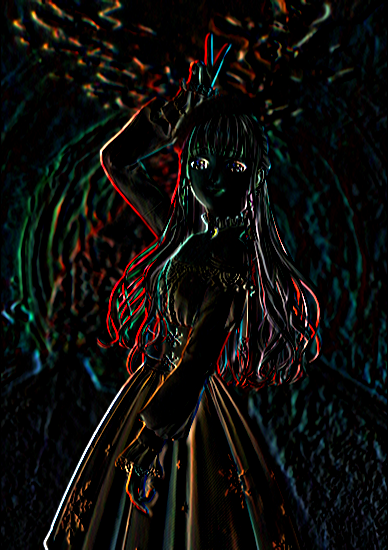

In [0]:
edgeY_img = cv2.filter2D(img, -1, grad_y)
cv2_imshow(edgeY_img)

#### 比较一下两个方向...

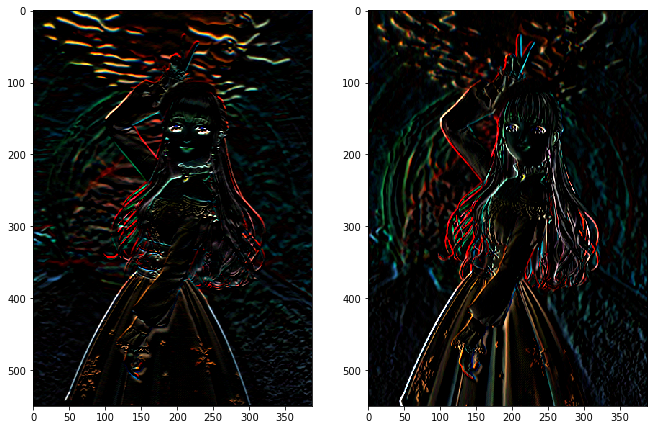

In [0]:
plt.figure(figsize=(int(W/70), int(H/70)))
plt.subplot(121)
plt.imshow(cv2.cvtColor(edgeX_img, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(edgeY_img, cv2.COLOR_BGR2RGB))
plt.show()

# II. Feature Point (Mid Level)

## 0. Why we need feature points?
* Classical CV → Image Stitching/ Classification/ Reconstruction → Look for pixels/objects representation → Feature Points

## 1. What is Feature Point?
* Represents of objects/pixels.

## 2. What is a good feature point?

### (1) Very informational
*  corner > edge > flat

(362, 360, 3)


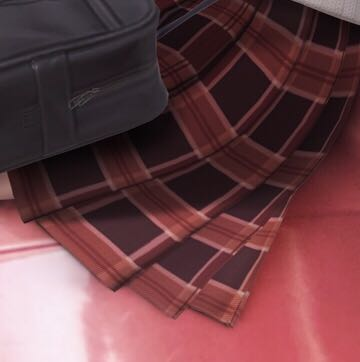

In [0]:
skirt = cv2.cvtColor(io.imread("https://drive.google.com/uc?id=1jPPrqbGPDCqOqISXjj7f2VNanNyZUyXg"), cv2.COLOR_RGB2BGR)
print(skirt.shape)
cv2_imshow(skirt)

小裙子借用一下~~

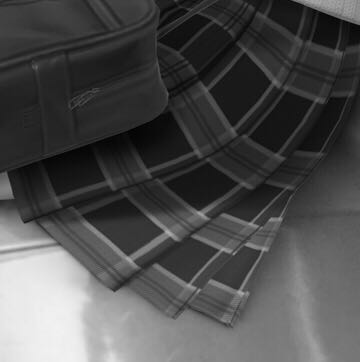

In [0]:
gray_skirt = np.float32(cv2.cvtColor(skirt, cv2.COLOR_BGR2GRAY))
cv2_imshow(gray_skirt)

#### 角点检测: Harris Corner Detector
定义一个窗口(block) $w$，令窗口在图像区域内移动，设沿x轴方向的位移量为u，沿y轴方向的位移量为v，**窗口函数**(平滑噪声,可以用Guassian)为$G(x, y)$，   
则移动后，窗口区域总信息量(灰度值)的变化量$V(u, v)$为:
>$V(u, v) = \sum_{(x, y)\in w} G(x, y)[I(x + u, y + v) - I(x, y)]^2$  

根据**Taylor展开公式**，  
>$I(x + u, y + v) = I(x, y) + \begin{pmatrix} I_x & I_y \end{pmatrix} \begin{pmatrix} u \\ 
v \end{pmatrix} $，  
$\Rightarrow V(u, v) = \sum_{(x, y)\in w} G(x, y)\Big[ \begin{pmatrix} I_x & I_y \end{pmatrix} \begin{pmatrix} u \\ 
v \end{pmatrix} \Big]^2 = \begin{pmatrix} u & v \end{pmatrix}\sum_{(x, y) \in w} G(x, y)\begin{pmatrix} I_x^2 & I_xI_y\\
I_xI_y & I_y^2 \end{pmatrix} \begin{pmatrix} u \\
v \end{pmatrix} $


其中，系数矩阵 $A = G(x, y)\begin{pmatrix} I_x^2 & I_xI_y \\ I_xI_y & I_y^2 \end{pmatrix}$是$I_x-I_y$坐标系中的椭圆方程(中心在原点)，  
设其特征值$\lambda_1, \lambda_2$分别表示椭圆在$I_x$轴和$I_y$轴上的半径，则:  
>$\begin{cases}
Flat: \lambda_1 和 \lambda_2 (同小);\\
Edge (e.g: vertical, I_x轴方向的大): \lambda_1大, \lambda_2小; \\
Corner: \lambda_1 和 \lambda_2 (同大).
\end{cases}$

特征值的分布与该点属性的关系:

![特征值的分布与该点属性的关系](https://img-blog.csdn.net/20180114172633468?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvdTAxNDQ4NTQ4NQ==/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)

>$\lambda_1 \times \lambda_2 = def(A)\\
\lambda_1 + \lambda_2 = tr(A)$

#### Harris function:
>$f = \lambda_1 \lambda_2 - k(\lambda_1 + \lambda_2)^2$

In [0]:
harris_skirt = cv2.cornerHarris(gray_skirt, blockSize=2, ksize=3, k=0.05)

#### Parameters:
   *  **blockSize** Neighborhood size (see the details on #cornerEigenValsAndVecs ).
   *  **ksize** Aperture parameter for the Sobel operator.
   *  **k** Harris detector free parameter. See the formula above.

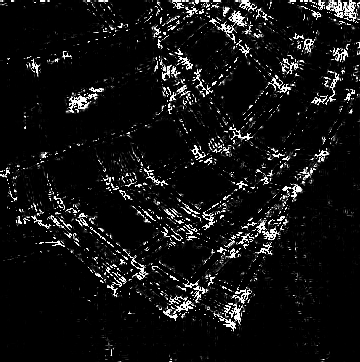

In [0]:
cv2_imshow(harris_skirt)

#### Ծ‸Ծ 没法看？原因：  
*  1.float类型；
*  2.$“harris\_skirt”$本质上是$“gray\_skirt”$的每个pixel对于$Harris$函数的响应值，没有看的价值。

In [0]:
print(harris_skirt)

[[ 1.72992706e+02  1.72992706e+02  3.04985901e+02 ... -1.63061646e+03
  -1.71953568e+02  3.35083466e+01]
 [ 1.72992706e+02  1.72992706e+02  3.04985901e+02 ... -1.63061646e+03
  -1.71953568e+02  3.35083466e+01]
 [-1.02812500e+02 -1.02812500e+02 -8.55859375e+00 ... -6.70397461e+02
   1.14885544e+02  7.07563660e+02]
 ...
 [ 3.41308601e-02  3.41308601e-02  3.41308564e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.02343720e-02  4.02343720e-02  2.20458984e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.43017575e-01 -1.43017575e-01  3.66210938e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


#### 为了显示清楚：设定阈值

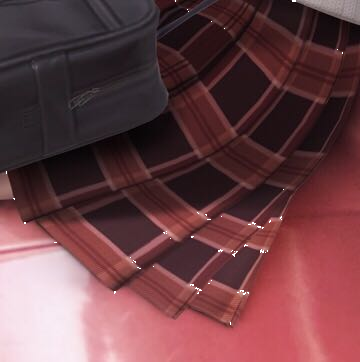

In [0]:
thres = 0.05 * np.max(harris_skirt)
corner_skirt = skirt
corner_skirt[harris_skirt > thres] = [255, 255, 255]
cv2_imshow(corner_skirt)

### (2) Rotation & Brightness resistance
* Corner point satisfied.

### (3) Scale resistance
* Corner point is not satisfied.

### (1) + (2) + (3) $\Rightarrow$ Good feature point
#### corner满足(1) + (2)，也还可以.

## 3. What is the form of feature point?

* Physical in location
* Abstract in formation (usually a vector)   
&emsp;&emsp;&emsp;$\Downarrow$  
**Feature Descriptor**

## 4. How to get a feature point / descriptor??

### (1) Generate Scale-Space: Dog (Difference of Gaussian)
* Gaussian Space $\Rightarrow$ Dog Space

>**生成尺度空间:**  
采用不同方差的Gaussian核，$\sigma$越大，图像越模糊，表示距离越远；$\sigma$越小，图像越清晰，表示距离越近。

>**快速找边缘:**
不同$sigma$的Gaussian平滑后，得到的image直接相减，即用1阶差分代替复杂的2阶导。

### (2) Scale-Space Extrema Detection
* Dog Space (Image Pyramid) $\Rightarrow$ 极值点: 空间 + 相邻尺度

### (3) Accrate Keypoint Location
* 极值点 $\Rightarrow$ **线性插值:** Dog函数对位移量$\left(\Delta x,\Delta y,\Delta \sigma \right)^T$导数为0 $\Rightarrow$ 精确定位

### (4) Eliminate Edge Response
* Dog对edge很敏感 $\Rightarrow$ Hessian矩阵 & Curvature **+** 设定阈值 $\Rightarrow$ 稳定的结果
---
<font color=#5F9EA0> 以上已经可以做到对尺度不变;
 接下来考虑对旋转不变: </font>

### (5) Orientation Assignment
* 梯度幅值 + 梯度幅角 $\Rightarrow$ 主方向

### (6) Keypoint Descriptor
* 旋转: 消除主方向角度 + $4 \times 4$ 网格划分 & 8个方向角度 + 归一化(消除光照影响) $\Rightarrow$ ($4 \times 4 \times 8$) = 128维vector: 描述子

### 5. Image Stitching
**Pipeline:**
  1. Find feature points in each image
  2. Use RANSAC to find keypoint matches
  3. Use homography matrix to get transferring info
  4. Merge two images